In [22]:
from functools import partial

import jax
import jax.numpy as np
import flax.linen as nn
import optax
import diffrax as dfx
import math
import distrax

from sklearn import datasets, preprocessing

import matplotlib.pyplot as plt
from tqdm import trange

## The Dataset

(-2.0, 2.0)

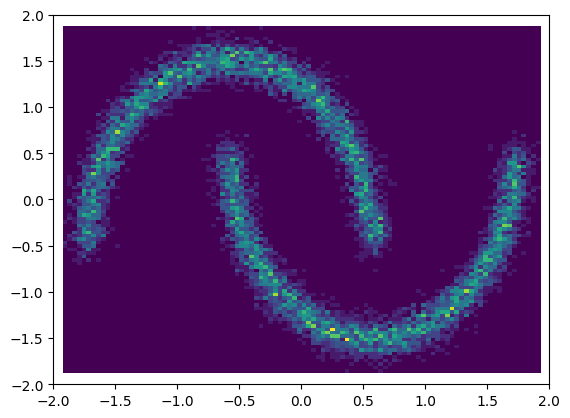

In [23]:
n_samples = 10_000

x, _ = datasets.make_moons(n_samples=n_samples, noise=.06)

scaler = preprocessing.StandardScaler()
x = scaler.fit_transform(x)

plt.hist2d(x[:, 0], x[:, 1], bins=100)
plt.xlim(-2 ,2)
plt.ylim(-2, 2)

## The Model

Based on https://docs.kidger.site/diffrax/examples/continuous_normalising_flow/.

In [24]:
class MLP(nn.Module):
    """ A simple MLP in Flax.
    """
    hidden_dim: int = 64
    out_dim: int = 2
    n_layers: int = 3

    @nn.compact
    def __call__(self, x):
        for _ in range(self.n_layers):
            x = nn.Dense(features=self.hidden_dim)(x)
            x = nn.gelu(x)
        x = nn.Dense(features=self.out_dim)(x)
        return x

In [25]:
key = jax.random.PRNGKey(0)
t = np.ones((x.shape[0], 1))

phi = MLP(hidden_dim=64, out_dim=2, n_layers=3)
params = phi.init(key, np.concatenate([x, t], axis=1))

The evolution of the log-density follows the instantaneous change0-of-variables formula:
$$\frac{\partial \log p(\mathbf{z}(t))}{\partial t}=-\operatorname{Tr}\left(\frac{\partial f}{\partial \mathbf{z}(t)}\right)$$

Get total change in log-density by integrating across time:
$$\log p\left(\mathbf{z}\left(t_1\right)\right)=\log p\left(\mathbf{z}\left(t_0\right)\right)-\int_{t_0}^{t_1} \operatorname{Tr}\left(\frac{\partial f}{\partial \mathbf{z}(t)}\right) d t$$

We can get an unbiased estimate of the trace of a matrix by taking a double product of that matrix with a noise vector.
$$\operatorname{Tr}(A)=E_{p(\boldsymbol{\epsilon})}\left[\boldsymbol{\epsilon}^T A \boldsymbol{\epsilon}\right]$$

In [35]:
def logp_exact(t, y, args):
    """ Compute trace directly.
    """
    y, _ = y
    _, func = args
    t = np.atleast_1d(t)

    # Augmented function
    fn = lambda y: func(np.concatenate([y, t]))

    # VJPs can be computed at the ~same cost as computing f through reverse-mode AD
    f, f_vjp = jax.vjp(fn, y)  

    # Compute trace
    (size,) = y.shape
    (dfdy,) = jax.vmap(f_vjp)(np.eye(size))
    logp = np.trace(dfdy)
    return f, logp

def logp_approx(t, y, args):
    """ Approx. trace using Hutchinson's trace estimator.
    """
    y, _ = y
    eps, func = args
    t = np.atleast_1d(t)
    
    # Augmented function
    fn = lambda y: func(np.concatenate([y, t]))

    # VJPs can be computed at the ~same cost as computing f through reverse-mode AD
    f, f_vjp = jax.vjp(fn, y)
    
    # Trace estimator
    (eps_dfdy,) = f_vjp(eps)
    logp = np.sum(eps_dfdy * eps)
    return f, logp

In [40]:
t0 = 0.0
t1 = 1
dt0 = 1e-2
log_like_mode = 'exact'  # 'exact' or 'approx'

# Runs backward-in-time to train the CNF
def loss_fn(params, y, phi):
    
    if log_like_mode == 'exact':
        term = dfx.ODETerm(logp_exact)
    elif log_like_mode == 'approx':
        term = dfx.ODETerm(logp_approx)
    else:
        raise NotImplementedError
    
    term = dfx.ODETerm(logp_exact)
    solver = dfx.Heun()
    eps = jax.random.normal(key, y.shape)
    delta_log_likelihood = 0.0
    y = (y, delta_log_likelihood)
    func = lambda x: phi.apply(params, x)
    sol = dfx.diffeqsolve(term, solver, t1, t0, -dt0, y, (eps, func))
    (y,), (delta_log_likelihood,) = sol.ys
    return delta_log_likelihood + distrax.Normal(loc=0, scale=1).log_prob(y).sum()

jax.vmap(loss_fn, in_axes=(None, 0, None))(params, x[:32], phi)

Array([-2.0769043, -3.6074724, -3.1181843, -3.0142238, -2.9132824,
       -1.8278964, -3.6776264, -2.5787375, -3.6398237, -3.0993927,
       -2.0480368, -3.1227055, -3.155456 , -3.41032  , -3.104731 ,
       -3.534789 , -2.921563 , -3.8766563, -2.3694816, -2.057131 ,
       -2.2559884, -3.5762784, -3.3718185, -3.7214563, -2.7325099,
       -2.9667323, -3.2967436, -2.912478 , -3.1135879, -2.5654173,
       -2.9415524, -2.9415376], dtype=float32)

## Train

In [41]:
opt = optax.adamw(learning_rate=3e-4, weight_decay=1e-4)
opt_state = opt.init(params)

@partial(jax.jit, static_argnums=(2,))
def loss_fn_vmapped_summed(params, x_batch, phi):
    log_like = jax.vmap(loss_fn, in_axes=(None, 0, None))(params, x_batch, phi)
    return -log_like.mean()


In [46]:
n_steps = 1000
n_batch = 32

with trange(n_steps) as steps:
    for step in steps:

        # Draw a random batches from x
        key, subkey = jax.random.split(key)
        idx = jax.random.choice(key, x.shape[0], shape=(n_batch,))
        
        x_batch = x[idx]
        
        loss, grads = jax.value_and_grad(loss_fn_vmapped_summed)(params, x_batch, phi)
        updates, opt_state = opt.update(grads, opt_state, params)

        params = optax.apply_updates(params, updates)

        steps.set_postfix(val=loss)

100%|██████████| 1000/1000 [02:21<00:00,  7.06it/s, val=1.672616]


## Sample

In [47]:
def single_sample_fn(params, key, n_dim=2):
    """ Produce single sample from the CNF by integrating forward.
    """
    y = jax.random.normal(key, (n_dim,))
    def func(t, x, args):
        t = np.atleast_1d(t)
        return phi.apply(params, np.concatenate([x, t]))
    term = dfx.ODETerm(func)
    solver = dfx.Heun()
    sol = dfx.diffeqsolve(term, solver, t0, t1, dt0, y)
    (y,) = sol.ys
    return y

single_sample_fn(params, key)

Array([ 1.0039548, -1.5377792], dtype=float32, weak_type=True)

In [50]:
sample_fn = partial(single_sample_fn, params)

n_samples = 1000
sample_key = jax.random.split(key, n_samples ** 2)
x_sample = jax.vmap(sample_fn)(sample_key)

(-2.0, 2.0)

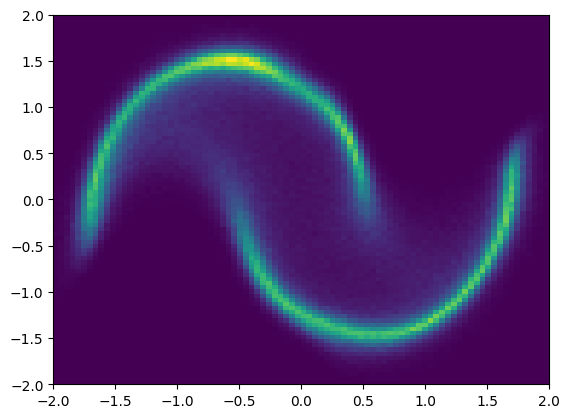

In [51]:

plt.hist2d(x_sample[:, 0], x_sample[:, 1], bins=100)
plt.xlim(-2 ,2)
plt.ylim(-2, 2)